<a href="https://colab.research.google.com/github/crsimmons1/lifeexpectancy/blob/master/Classification/Logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Logistic Regression for Classification of Expenditure**
## **Introduction**
This file uses support vector machines to classify whether the Total Expenditure (general government expenditure on health as a percentage of total government expenditure (%)) was low or high for various countries for the years 2000-2015. The threshold chosen to distinguish low(1)  and high(1) is 5.8%, since it is the median value and keeps the classes balanced.  

This data can be found [here](https://www.kaggle.com/kumarajarshi/life-expectancy-who) on Kaggle. Please see this git [repository](https://github.com/crsimmons1/lifeexpectancy) for more information on the data cleaning that was done. 

The explanatory variables included are:
* **LifeExpectancy** in age
* **AdultMortality** Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)
* **InfantDeaths** Number of Infant Deaths per 1,000 population
* **Alcohol**, recorded per capita (15+) consumption (in litres of pure alcohol)
* **HepB** (Hepatitis B) immunization coverage among 1-year-olds (%)
* **Measles** - number of reported cases per 1000 population
* **BMI** Average Body Mass Index of entire population
* **5deaths** Number of under-five deaths per 1000 population
* **Polio** (Pol3) immunization coverage among 1-year-olds (%)
* **Diphtheria** tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)
* **HIV** Deaths per 1,000 live births HIV/AIDS (0-4 years)
* **GDP** Gross Domestic Product per capita (in USD)
* **Population** of the country
* **ThinJuvenile** Prevalence of thinness among children and adolescents for Age 10 to 19 (% )
* **ThinChild** Prevalence of thinness among children for Age 5 to 9(%)
* **IncomeComp** Human Development Index in terms of income composition of resources (index ranging from 0 to 1)
* **Schooling** Number of years of Schooling(years)

## **Overview of Analysis and Results**

Model 1 was fitted with basic logistic regression. For model 2, all of the variables were scaled. This increased the accuracy 56.4% to 65.7%. Since it is unlikely that all of the features are contributing to the model equally, or at all, the next step is selecting the most important features and dropping the ones that do not contribute. 

Then, the importance was assessed using recursive feature elimination (RFE) for the next two models. Model 3 removed any features that were below 0.05, which was all three of the immunization variables (Polio, Diphtheria, Measles) and BMI. Model 4 removed the six features that were below 0.1, so Adult Mortality and GDP were also removed. This makes sense considering that GDP and Hepatitis B were both columns with a lot of missing values that were filled in with imputing. Model 4 had the highest accuracy so far, increasing to 65.9%

The next step is to tune the parameters to ensure the best possible fit. To avoid overfitting during the process, cross validation is used. The most important parameters are penalty, which helps to avoid having the model overfit, and the strength of that penalty. 

Model 5 tunes the parameters for penalty and the inverse of the regularization strength using grid search with CV=5. Logistic regression defaults with an l2 penalty, so all available options were considered (l1, none, and elastic net). C is a parameter that indicated the inverse of the regularization strength(larger values specify weaker regularization). A range of this, both above and below 1 will allow us to tune how strong each penalty is. This model improved the accuracy to 66.1%, which is not a great improvement most likely because l2 ended up being the best parameter. C was selected for 0.1, indicating a strong penalty was applied. 

Model 6 tunes the parameter even further, also using grid search with CV=5. Working with the l2 penalty selected in model 5, several different solvers were put it. A solver is the algorithm used for the optimization problem. The range of possible C values was also increased, with less space between them. A stronger penalty was selected, with C=0.05. The solver selected was newton-cg.  The accuracy decreased slightly to 65.9%. 

The best model is likely model 6, even with decreased accuracy compared to model 5. It might simply be that model 5 found a local minimum that exists only with cross validation. Model 5 uses a lbfgs solver, which may get stuck at a non-optimal point if the level curves are not smooth. 



## **Import the Data**


In [93]:
# Import Packages
import pandas as pd
import numpy as np

# Import Unscaled Data
data= pd.read_csv("cleaned_data.csv")

# Split in X and y 
y = pd.DataFrame(data.TExp)
X = data.drop(columns=['TExpenditure', 'Expenditure','TExp', 'Year', 'Status'])

#Train-test split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=33)

data.head(5)

,Status,Year,LifeExpectancy,AdultMortality,InfantDeaths,Alcohol,Expenditure,HepB,Measles,BMI,5deaths,Polio,TExpenditure,Diphtheria,HIV,GDP,Population,ThinJuvenile,ThinChild,IncomeComp,Schooling,TExp
0,0,2015.0,65.0,263.0,62.0,0.01,71.279624,65.0,1154.0,19.1,83.0,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,1
1,0,2014.0,59.9,271.0,64.0,0.01,73.523582,62.0,492.0,18.6,86.0,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,1
2,0,2013.0,59.9,268.0,66.0,0.01,73.219243,64.0,430.0,18.1,89.0,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,1
3,0,2012.0,59.5,272.0,69.0,0.01,78.184215,67.0,2787.0,17.6,93.0,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,1
4,0,2011.0,59.2,275.0,71.0,0.01,7.097109,68.0,3013.0,17.2,97.0,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,1


## **Initial Fitting**
### Model 1

In [94]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [95]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.56
              precision    recall  f1-score   support

           0       0.60      0.53      0.56       269
           1       0.53      0.61      0.57       238

    accuracy                           0.56       507
   macro avg       0.57      0.57      0.56       507
weighted avg       0.57      0.56      0.56       507



In [96]:
from sklearn import metrics

# Function to evaluate model 
RESULTS = {}
def evaluate_model(y_test, y_train, y_pred_test, y_pred_train):
    return { # First test, then training 
        # Accuracy
        "Accuracy_test" : metrics.accuracy_score(y_test, y_pred_test),
        "Accuracy_train" : metrics.accuracy_score(y_train, y_pred_train),
        # AUC
        "AUC_test" : (metrics.roc_auc_score(y_test, y_pred_test)),
        "AUC_train" : (metrics.roc_auc_score(y_train, y_pred_train)),
        # Average Precision Score
        "AvgPrecision_test": metrics.average_precision_score(y_test, y_pred_test),
        "AvgPrecision_train": metrics.average_precision_score(y_train, y_pred_train),
        # F1 Score, also known as balanced F-score or F-measure
        "F1_test": metrics.f1_score(y_test, y_pred_test),
        "F1_train": metrics.f1_score(y_train, y_pred_train)}

# calculate metrics for the training and test predictions
y_pred_train = logreg.predict(X_train)
y_pred_test = logreg.predict(X_test)
RESULTS["Initial"] = evaluate_model(y_test, y_train, y_pred_test,y_pred_train)

# Output the metrics
pd.DataFrame(RESULTS)

,Initial
AUC_test,0.566462
AUC_train,0.572876
Accuracy_test,0.564103
Accuracy_train,0.571852
AvgPrecision_test,0.506903
AvgPrecision_train,0.534437
F1_test,0.565815
F1_train,0.599538


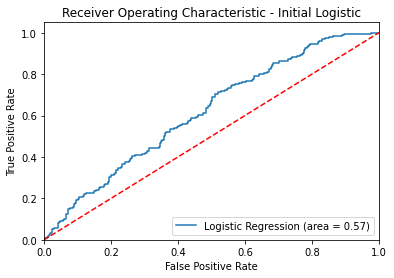

In [97]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Initial Logistic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

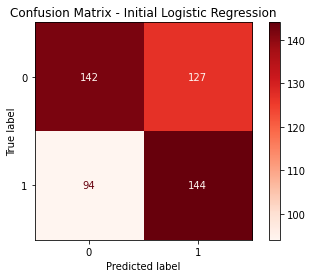

In [98]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(logreg, X_test, y_test, values_format='d', cmap='Reds')
plt.title("Confusion Matrix - Initial Logistic Regression")
plt.show()

## **Feature Selection and Scaling**
### Model 2 - Scaled 

In [0]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the training data and transform
X_train = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)

# Apply the scaler to the test data
X_test = pd.DataFrame(sc.transform(X_test), columns=X_train.columns)

In [8]:
X_train.head(5)

,LifeExpectancy,AdultMortality,InfantDeaths,Alcohol,HepB,Measles,BMI,5deaths,Polio,Diphtheria,HIV,GDP,Population,ThinJuvenile,ThinChild,IncomeComp,Schooling
0,0.612831,-0.199625,-0.182163,-0.170073,0.499629,-0.201610,-1.703877,-0.196119,0.350160,0.479066,-0.315715,-0.205350,0.029570,-0.787360,-0.800328,0.341004,0.317519
1,1.097265,-0.593504,-0.239988,1.929811,0.737977,-0.201151,0.988580,-0.244786,0.612198,0.651407,-0.315715,1.102629,-0.201657,-0.919042,-0.951772,0.869828,1.222636
2,-1.669395,-1.003460,-0.198685,-0.363022,-0.394424,-0.201610,-1.850922,-0.196119,-0.435953,-0.641151,0.647695,-0.479393,-0.199717,0.946452,0.887188,-3.033855,-1.274238
3,-0.173030,-0.062973,-0.182163,-1.002009,-1.089356,-0.020234,0.253352,-0.196119,-0.173915,-0.253384,-0.315715,-0.446578,-0.200608,-0.414262,-0.410901,0.134282,-0.400332
4,1.075735,-0.625658,-0.223467,1.330918,0.181832,-0.201610,0.993650,-0.232619,0.524852,0.565236,-0.315715,0.586462,-0.194257,-0.940989,-0.951772,0.932326,1.129003


In [9]:
logreg2 = LogisticRegression()
logreg2.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
from sklearn.feature_selection import RFE
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 3)
fit = rfe.fit(X_train, y_train)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Num Features: 3
Selected Features: [False False  True  True False False False  True False False False False
 False False False False False]
Feature Ranking: [ 4 11  1  1  9 15 12  1 13 14  3 10  8  7  2  5  6]


Feature: 0, Score: 0.27036
Feature: 1, Score: -0.07245
Feature: 2, Score: -1.21057
Feature: 3, Score: 0.59312
Feature: 4, Score: 0.13213
Feature: 5, Score: -0.03831
Feature: 6, Score: 0.04599
Feature: 7, Score: 0.76840
Feature: 8, Score: -0.04595
Feature: 9, Score: 0.04483
Feature: 10, Score: 0.35054
Feature: 11, Score: -0.07310
Feature: 12, Score: -0.17266
Feature: 13, Score: 0.16472
Feature: 14, Score: -0.49608
Feature: 15, Score: -0.34947
Feature: 16, Score: 0.18713


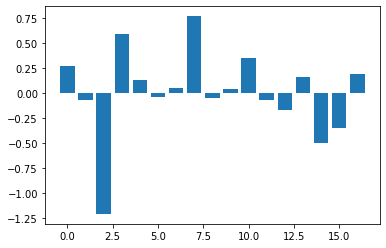

In [11]:
# get importance
importance = logreg2.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [12]:
# calculate metrics for the training and test predictions
y_pred_train = logreg2.predict(X_train)
y_pred_test = logreg2.predict(X_test)
RESULTS["Scaled"] = evaluate_model(y_test, y_train, y_pred_test,y_pred_train)

# output the predictions
pd.DataFrame(RESULTS)

,Initial,Scaled
Accuracy_test,0.564103,0.656805
Accuracy_train,0.571852,0.693827
AUC_test,0.566462,0.655759
AUC_train,0.572876,0.693733
AvgPrecision_test,0.506903,0.574107
AvgPrecision_train,0.534437,0.628956
F1_test,0.565815,0.635983
F1_train,0.599538,0.688755


### Model 3 - remove 4 features

In [13]:
# Now remove features 5,6,8 and 9 
X_train.columns


Index(['LifeExpectancy', 'AdultMortality', 'InfantDeaths', 'Alcohol', 'HepB',
       'Measles', 'BMI', '5deaths', 'Polio', 'Diphtheria', 'HIV', 'GDP',
       'Population', 'ThinJuvenile', 'ThinChild', 'IncomeComp', 'Schooling'],
      dtype='object')

In [0]:
X_train = X_train.drop(columns=['Measles', 'BMI','Polio', 'Diphtheria'])
X_test = X_test.drop(columns=['Measles', 'BMI','Polio', 'Diphtheria'])

In [15]:
# Fit new model 
logreg3 = LogisticRegression()
logreg3.fit(X_train, y_train)

#Make predictions 
y_pred_train = logreg3.predict(X_train)
y_pred_test = logreg3.predict(X_test)

# Evaluation metrics
RESULTS["Scaled_drop4"] = evaluate_model(y_test, y_train, y_pred_test,y_pred_train)
pd.DataFrame(RESULTS)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Initial,Scaled,Scaled_drop4
Accuracy_test,0.564103,0.656805,0.654832
Accuracy_train,0.571852,0.693827,0.696296
AUC_test,0.566462,0.655759,0.654384
AUC_train,0.572876,0.693733,0.696196
AvgPrecision_test,0.506903,0.574107,0.572403
AvgPrecision_train,0.534437,0.628956,0.631219
F1_test,0.565815,0.635983,0.637681
F1_train,0.599538,0.688755,0.691110


### Model 4 - remove 6 total features

In [0]:
# Now drop feature 1 and 11
X_train = X_train.drop(columns=['AdultMortality', 'GDP'])
X_test = X_test.drop(columns=['AdultMortality', 'GDP'])

In [17]:
# Fit new model 
logreg3.fit(X_train, y_train)

#Make predictions 
y_pred_train = logreg3.predict(X_train)
y_pred_test = logreg3.predict(X_test)

# Evaluation metrics
RESULTS["Scaled_drop6"] = evaluate_model(y_test, y_train, y_pred_test,y_pred_train)
pd.DataFrame(RESULTS)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Initial,Scaled,Scaled_drop4,Scaled_drop6
Accuracy_test,0.564103,0.656805,0.654832,0.658777
Accuracy_train,0.571852,0.693827,0.696296,0.700247
AUC_test,0.566462,0.655759,0.654384,0.657618
AUC_train,0.572876,0.693733,0.696196,0.700082
AvgPrecision_test,0.506903,0.574107,0.572403,0.575799
AvgPrecision_train,0.534437,0.628956,0.631219,0.635175
F1_test,0.565815,0.635983,0.637681,0.637317
F1_train,0.599538,0.688755,0.691110,0.693589


## **Parameter Tuning with Grid Search**
### Model 5 - Penalty and Inverse of Regularization Strength


In [0]:
from sklearn.model_selection import GridSearchCV 

# Set paramters to be tuned
param_grid = { 
    'penalty': ['l1','elasticnet','l2', 'none'], 
    'C': [0.01,0.1,0.5,1,2,5,10]
}

In [0]:
grid = GridSearchCV(estimator = logreg, param_grid=param_grid, 
                          cv = 5, verbose = 51, n_jobs=-1)

logreg = LogisticRegression()

In [63]:
import time 

t_start = time.time()
grid.fit(X_train, y_train)
t_end = time.time()

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0139s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0233s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1128s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:  

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [64]:
best = grid.best_estimator_
best

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [65]:
# Fit new model 
best.fit(X_train, y_train)

#Make predictions 
y_pred_train = best.predict(X_train)
y_pred_test = best.predict(X_test)

# Evaluation metrics
RESULTS["Scaled_tuned"] = evaluate_model(y_test, y_train, y_pred_test,y_pred_train)
pd.DataFrame(RESULTS)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Initial,Scaled,Scaled_drop4,Scaled_drop6,Scaled_tuned,Scaled_tuned2
Accuracy_test,0.564103,0.656805,0.654832,0.658777,0.660750,0.658777
Accuracy_train,0.571852,0.693827,0.696296,0.700247,0.702716,0.701235
AUC_test,0.566462,0.655759,0.654384,0.657618,0.659234,0.657376
AUC_train,0.572876,0.693733,0.696196,0.700082,0.702584,0.701122
AvgPrecision_test,0.506903,0.574107,0.572403,0.575799,0.577541,0.575828
AvgPrecision_train,0.534437,0.628956,0.631219,0.635175,0.637262,0.635790
F1_test,0.565815,0.635983,0.637681,0.637317,0.637131,0.635789
F1_train,0.599538,0.688755,0.691110,0.693589,0.696878,0.695827


### Model 6 - Tune Inverse of Regularization Strength and Solver for l2 Penalty

In [0]:
from sklearn.model_selection import GridSearchCV 

# Set paramters to be tuned
param_grid2 = { 
    'C': [0.01,0.05,0.1,0.25,0.5,1],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}

In [0]:
grid2 = GridSearchCV(estimator = logreg, param_grid=param_grid2, 
                          cv = 5, verbose = 51, n_jobs=-1)

logreg = LogisticRegression(penalty='l2')

In [58]:
import time 

t_start = time.time()
grid2.fit(X_train, y_train)
t_end = time.time()

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [59]:
best2 = grid2.best_estimator_
best2

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
# Fit new model 
best2.fit(X_train, y_train)

#Make predictions 
y_pred_train = best2.predict(X_train)
y_pred_test = best2.predict(X_test)

# Evaluation metrics
RESULTS["Scaled_tuned2"] = evaluate_model(y_test, y_train, y_pred_test,y_pred_train)
pd.DataFrame(RESULTS)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Initial,Scaled,Scaled_drop4,Scaled_drop6,Scaled_tuned,Scaled_tuned2
Accuracy_test,0.564103,0.656805,0.654832,0.658777,0.660750,0.658777
Accuracy_train,0.571852,0.693827,0.696296,0.700247,0.702716,0.701235
AUC_test,0.566462,0.655759,0.654384,0.657618,0.659234,0.657376
AUC_train,0.572876,0.693733,0.696196,0.700082,0.702584,0.701122
AvgPrecision_test,0.506903,0.574107,0.572403,0.575799,0.577541,0.575828
AvgPrecision_train,0.534437,0.628956,0.631219,0.635175,0.637262,0.635790
F1_test,0.565815,0.635983,0.637681,0.637317,0.637131,0.635789
F1_train,0.599538,0.688755,0.691110,0.693589,0.696878,0.695827


In [92]:
# plot curve
logit_roc_auc = roc_auc_score(y_test, best2.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, best2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Best Logistic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

ValueError: ignored

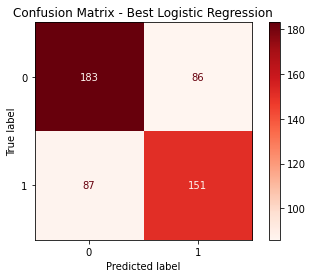

In [83]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(best2, X_test, y_test, values_format='d', cmap='Reds')
plt.title("Confusion Matrix - Best Logistic Regression")
plt.show()